In [1]:
import numpy as np
import scipy as sp
import datetime as dt

import matplotlib
from matplotlib import animation
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
%matplotlib inline

# Geotherm

In [3]:
def geotherm(z,d,k,qd,a):
    """
    returns temp at depth (z) given thickness (d), conductivity (k), basal heat (qd) and internal heat (a)
    """
    
    return -(a/(2*k))*(z**2) + ((qd+(a*d))/(k))*z

In [4]:
zz = np.linspace(0,60e3,100) # 100 m steps up to 60 km

In [5]:
case_A = {'id':'A', 'd':50e3, 'k':2.5, 'a':1.25e-6, 'qd':21e-3}
case_B = {'id':'B', 'd':50e3, 'k':1.7, 'a':1.25e-6, 'qd':21e-3}
case_C = {'id':'C', 'd':50e3, 'k':2.5, 'a':2.50e-6, 'qd':21e-3}
case_D = {'id':'D', 'd':50e3, 'k':2.5, 'a':1.25e-6, 'qd':42e-3}
case_E = {'id':'E', 'd':50e3, 'k':2.5, 'a':1.25e-6, 'qd':10.5e-3}
cases = [case_A, case_B, case_C, case_D, case_E]

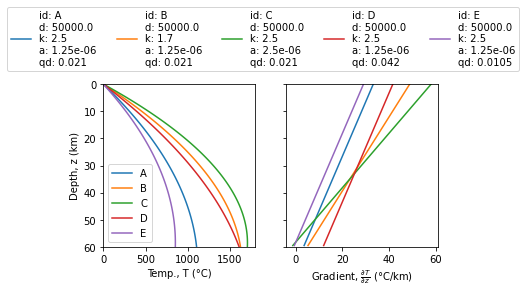

In [6]:
fig = plt.figure(figsize=(6,3))
ax = fig.subplots(1,2,sharey=True)

for case in cases:
    ax[0].plot(geotherm(zz,case['d'],case['k'],case['qd'],case['a']),zz/1e3,'-',label=case['id'])
    ax[1].plot(1e3*np.diff(geotherm(zz,case['d'],case['k'],case['qd'],case['a']))/np.diff(zz),zz[:-1]/1e3,'-',
               label='\n'.join([('%s: %s')%(key,val) for key,val in case.items()])
              )

ax[0].set_ylabel('Depth, z (km)')
    
ax[0].set_xlabel('Temp., T (°C)')
ax[1].set_xlabel(r'Gradient, $\frac{\partial{T}}{\partial{z}}$ (°C/km)')
    
ax[0].legend()
ax[1].legend(bbox_to_anchor=(-0.15,1.05),loc='lower center',ncol=len(cases))


[aa.set_ylim([60,0]) for aa in ax.flat]
ax[0].set_xlim([0,1800]);

# 2 layer geotherm

In [7]:
def geotherm_twolayer(z,z1,z2,k,qd,a1,a2):
    """
    returns temp at depth (z) given thickness (d), conductivity (k), basal heat (qd) and internal heat (a)
    """
    
    if z<z1:
        return -a1/(2*k)*z**2 + (qd/k + (a2/k)*(z2-z1) + (a1*z1)/k)*z
    else:
        return -a2/(2*k)*z**2 + (qd/k + (a2*z2/k))*z + (a1-a2)/(2*k)*z1**2

In [8]:
case2_A = {'id':'A', 'z1':20e3, 'z2':15e3, 'k':2.5, 'qd':63e-3, 'a1': 4.2e-6, 'a2': 0.8e-6}

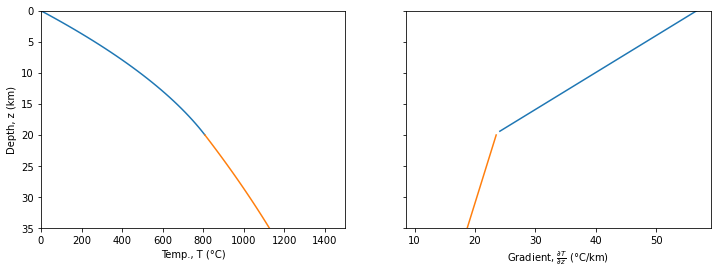

In [9]:
fig = plt.figure(figsize=(12,4))
ax = fig.subplots(1,2,sharey=True)

ax[0].plot([geotherm_twolayer(z,
                           case2_A['z1'],case2_A['z2'],
                           case2_A['k'],case2_A['qd'],
                           case2_A['a1'],case2_A['a2']) for z in zz[zz<=case2_A['z1']]],
        zz[zz<=case2_A['z1']]/1e3,'-')

ax[0].plot([geotherm_twolayer(z,
                           case2_A['z1'],case2_A['z2'],
                           case2_A['k'],case2_A['qd'],
                           case2_A['a1'],case2_A['a2']) for z in zz[zz>=case2_A['z1']]],
        zz[zz>=case2_A['z1']]/1e3,'-')

############

ax[1].plot(np.diff([1e3*geotherm_twolayer(z,case2_A['z1'],case2_A['z2'],
                                      case2_A['k'],case2_A['qd'],
                                      case2_A['a1'],
                                      case2_A['a2']) for z in zz[zz<=case2_A['z1']]])/np.diff(zz[zz<=case2_A['z1']]),
        zz[zz<=case2_A['z1']][:-1]/1e3,'-',color='tab:blue')

ax[1].plot(np.diff([1e3*geotherm_twolayer(z,case2_A['z1'],case2_A['z2'],
                                      case2_A['k'],case2_A['qd'],
                                      case2_A['a1'],
                                      case2_A['a2']) for z in zz[zz>=case2_A['z1']]])/np.diff(zz[zz>=case2_A['z1']]),
        zz[zz>=case2_A['z1']][:-1]/1e3,'-',color='tab:orange')

###########

ax[0].set_ylim([(case2_A['z1']+case2_A['z2'])/1e3,0])
ax[0].set_xlim([0,1500])

ax[0].set_ylabel('Depth, z (km)')   
ax[0].set_xlabel('Temp., T (°C)')
ax[1].set_xlabel(r'Gradient, $\frac{\partial{T}}{\partial{z}}$ (°C/km)');


# Geotherm changes over time

# Heating and cooling

Scenario: Dike of width 2w, no internal heat generation, initial temperature T0, ignore latent heat<br>
initial conditions:<br>i) T=T0 at t=0 for -w <= x <= w<br>ii) T=0 at t=0 for |x|>=w

In [10]:
def tempdist(x,t,w,t0,k):
    """
    return temperature (degC) at given distance (x) and time (t) for 
    emplaced dike of width 2w at initial temp t0 and diffusivity of k
    """
    return (t0/2)*(sp.special.erf((w-x)/(2*np.sqrt(k*t)))+sp.special.erf((w+x)/(2*np.sqrt(k*t))))

In [11]:
days = [dt.timedelta(days=t).total_seconds() for t in range(8)] # 1 week in days
weeks = [dt.timedelta(weeks=t).total_seconds() for t in range(1,53)] # 1 year in weeks
years = [dt.timedelta(days=t*365.25).total_seconds() for t in range(1,101)] # 100 years

/var/folders/1s/wjx12t_j5h7gnb2g26c4dv8h0000gn/T/ipykernel_46015/802089117.py:6: RuntimeWarning: divide by zero encountered in true_divide
  return (t0/2)*(sp.special.erf((w-x)/(2*np.sqrt(k*t)))+sp.special.erf((w+x)/(2*np.sqrt(k*t))))


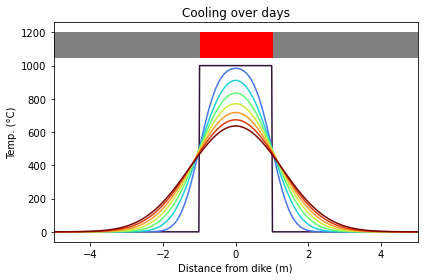

In [12]:
w = 1 # meter half-width
t0 = 1000 # initial temp
k = 1e-6 # diffusivity

xx = np.linspace(-10,10,1000)
cmap = plt.cm.turbo(np.linspace(0,1,len(days)))

fig = plt.figure()
ax = fig.subplots(1,1)

for tt,cc in zip(days,cmap):
    ax.plot(xx,tempdist(xx,tt,w,t0,k),'-',color=cc)

ax.set_xlim([-5,5])

# getting fancy
ax.fill_between(xx[(xx<-w)&(xx>ax.get_xlim()[0])],
                 np.ones_like(xx[(xx<-w)&(xx>ax.get_xlim()[0])])*(t0+200),
                 np.ones_like(xx[(xx<-w)&(xx>ax.get_xlim()[0])])*(t0+50),
                 color='grey', clip_on=True)
ax.fill_between(xx[(xx>w)&(xx<ax.get_xlim()[1])],
                 np.ones_like(xx[(xx>w)&(xx<ax.get_xlim()[1])])*(t0+200),
                 np.ones_like(xx[(xx>w)&(xx<ax.get_xlim()[1])])*(t0+50),
                 color='grey', clip_on=True)
ax.fill_between(xx[(xx>-w)&(xx<w)],
                 np.ones_like(xx[(xx>-w)&(xx<w)])*(t0+200),
                 np.ones_like(xx[(xx>-w)&(xx<w)])*(t0+50),
                 color='red', clip_on=True)

ax.set_title('Cooling over days')
ax.set_xlabel('Distance from dike (m)')
ax.set_ylabel('Temp. (°C)')
fig.tight_layout();

In [13]:
tempdist(0,days[-1],w,t0,k)

636.7771840057527

Text(0, 0.5, 'Temp. (°C)')

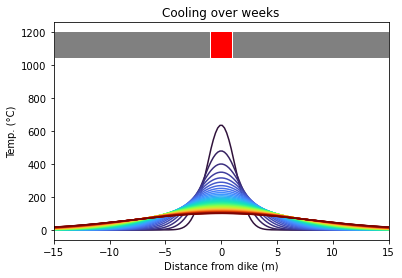

In [14]:
w = 1 # meter half-width
t0 = 1000 # initial temp
k = 1e-6 # diffusivity

xx = np.linspace(-100,100,1000)
cmap = plt.cm.turbo(np.linspace(0,1,len(weeks)))

fig = plt.figure()
ax = fig.subplots(1,1)

for tt,cc in zip(weeks,cmap):
    ax.plot(xx,tempdist(xx,tt,w,t0,k),'-',color=cc)
ax.set_xlim([-15,15])


# getting fancy
ax.fill_between(xx[(xx<-w)&(xx>ax.get_xlim()[0])],
                 np.ones_like(xx[(xx<-w)&(xx>ax.get_xlim()[0])])*(t0+200),
                 np.ones_like(xx[(xx<-w)&(xx>ax.get_xlim()[0])])*(t0+50),
                 color='grey', clip_on=True)
ax.fill_between(xx[(xx>w)&(xx<ax.get_xlim()[1])],
                 np.ones_like(xx[(xx>w)&(xx<ax.get_xlim()[1])])*(t0+200),
                 np.ones_like(xx[(xx>w)&(xx<ax.get_xlim()[1])])*(t0+50),
                 color='grey', clip_on=True)
ax.fill_between(xx[(xx>-w)&(xx<w)],
                 np.ones_like(xx[(xx>-w)&(xx<w)])*(t0+200),
                 np.ones_like(xx[(xx>-w)&(xx<w)])*(t0+50),
                 color='red', clip_on=True)

ax.set_title('Cooling over weeks')
ax.set_xlabel('Distance from dike (m)')
ax.set_ylabel('Temp. (°C)')

In [15]:
tempdist(0,weeks[3],w,t0,k)

350.6177913504624

In [16]:
tempdist(0,weeks[51],w,t0,k)

100.33858015599195

Text(0, 0.5, 'Temp. (°C)')

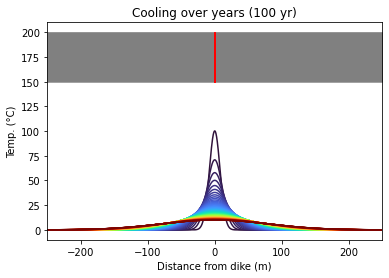

In [17]:
w = 1 # meter half-width
t0 = 1000 # initial temp
k = 1e-6 # diffusivity

xx = np.linspace(-250,250,10000)
cmap = plt.cm.turbo(np.linspace(0,1,len(years)))

fig = plt.figure()
ax = fig.subplots(1,1)

for tt,cc in zip(years,cmap):
    ax.plot(xx,tempdist(xx,tt,w,t0,k),'-',color=cc)
ax.set_xlim([-250,250])

# getting fancy
ax.fill_between(xx[(xx<-w)&(xx>ax.get_xlim()[0])],
                 np.ones_like(xx[(xx<-w)&(xx>ax.get_xlim()[0])])*(200),
                 np.ones_like(xx[(xx<-w)&(xx>ax.get_xlim()[0])])*(150),
                 color='grey', clip_on=True)
ax.fill_between(xx[(xx>w)&(xx<ax.get_xlim()[1])],
                 np.ones_like(xx[(xx>w)&(xx<ax.get_xlim()[1])])*(200),
                 np.ones_like(xx[(xx>w)&(xx<ax.get_xlim()[1])])*(150),
                 color='grey', clip_on=True)
ax.fill_between(xx[(xx>-w)&(xx<w)],
                 np.ones_like(xx[(xx>-w)&(xx<w)])*(200),
                 np.ones_like(xx[(xx>-w)&(xx<w)])*(150),
                 color='red', clip_on=True)

ax.set_title('Cooling over years (100 yr)')
ax.set_xlabel('Distance from dike (m)')
ax.set_ylabel('Temp. (°C)')

# Periodic variation

In [18]:
fztp = lambda z,t,t0,ww,p,cp,k: t0*np.exp(1j*ww*t)*np.exp(-(1+1j)*z*np.sqrt((ww*p*cp)/(2*k)))

k = 2.5
cp = 1e3
p = 2.3e3
fw = lambda t:(2*np.pi)/t


fL = lambda ww : np.sqrt((2*k)/(ww*p*cp))
fPhi = lambda z,ww : z*np.sqrt((ww*p*cp)/(2*k))

/Users/rkbono/miniconda3/lib/python3.8/site-packages/numpy/ma/core.py:2829: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/rkbono/miniconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/rkbono/miniconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


L: 0.17; ɸ: 1.00


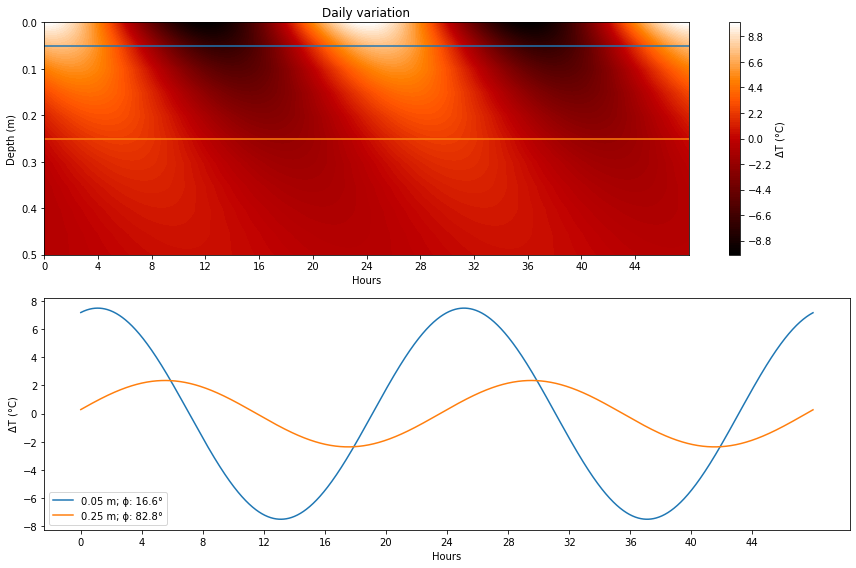

In [19]:
t0 = 10

# plt.plot(tt,fztp(0,tt,t0,ww,p,cp,k),'-')
tau = dt.timedelta(days=1).total_seconds()
ww = fw(tau)
ndays = 2
tt = np.arange(dt.timedelta(days=ndays).total_seconds())[::100]
dd = np.linspace(0,5,100)

ddc = [0.05,0.25]

xtm,ytm = np.meshgrid(tt,dd)

fig = plt.figure(figsize=(12,8))
ax = fig.subplots(2,1)

ff = ax[0].contourf(xtm,ytm,fztp(ytm,xtm,t0,ww,p,cp,k),cmap='gist_heat',levels=100)

ax[0].axhline(ddc[0],color='tab:blue')
ax[0].axhline(ddc[1],color='tab:orange')

ax[0].set_xticks([dt.timedelta(hours=int(x)).total_seconds() for x in np.arange(ndays*24)][::4],
              labels=np.arange(ndays*24)[::4])
ax[0].set_ylim([0.5,0])
ax[0].set_xlabel('Hours')
ax[0].set_ylabel('Depth (m)')
ax[0].set_title('Daily variation');
fig.colorbar(ff,ax=ax[0],label='ΔT (°C)');

for td in ddc:
    ax[1].plot(tt,fztp(td,tt,t0,ww,p,cp,k),'-',label='%.2f m; ɸ: %.1f°'%(td,np.degrees(fPhi(td,ww))))
ax[1].legend()
ax[1].set_ylabel('ΔT (°C)')
ax[1].set_xticks([dt.timedelta(hours=int(x)).total_seconds() for x in np.arange(ndays*24)][::4],
              labels=np.arange(ndays*24)[::4])
ax[1].set_xlabel('Hours')    

fig.tight_layout();

print('L: %.2f; ɸ: %.2f'%(fL(ww),fPhi(fL(ww),ww)))

/Users/rkbono/miniconda3/lib/python3.8/site-packages/numpy/ma/core.py:2829: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/rkbono/miniconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/rkbono/miniconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


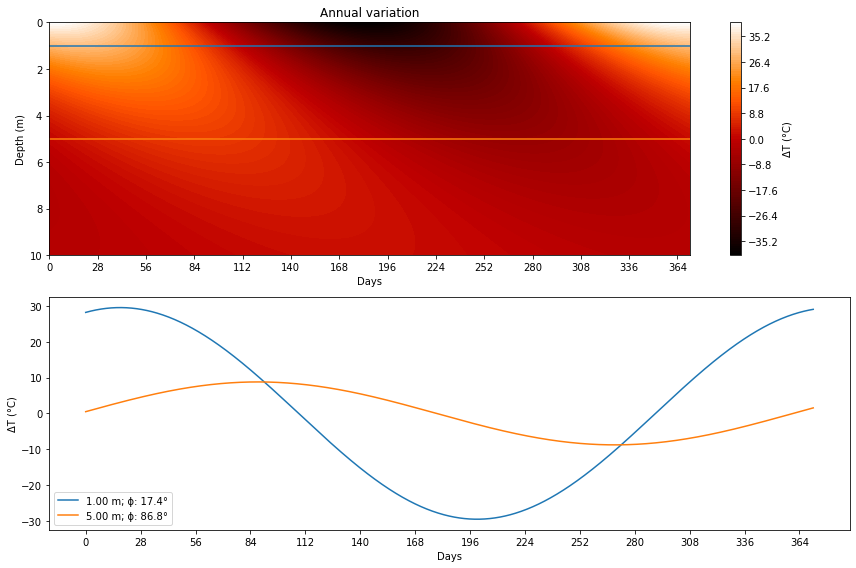

In [20]:

t0 = 40

# plt.plot(tt,fztp(0,tt,t0,ww,p,cp,k),'-')
tau = dt.timedelta(weeks=52).total_seconds()
ww = fw(tau)

nweeks = 53
tt = np.linspace(0,dt.timedelta(weeks=nweeks).total_seconds(),1000)
dd = np.linspace(0,15,100)

xtm,ytm = np.meshgrid(tt,dd)
dd = np.linspace(0,15,100)

ddc = [1,5]

xtm,ytm = np.meshgrid(tt,dd)

fig = plt.figure(figsize=(12,8))
ax = fig.subplots(2,1)

ff = ax[0].contourf(xtm,ytm,fztp(ytm,xtm,t0,ww,p,cp,k),cmap='gist_heat',levels=100)

ax[0].axhline(ddc[0],color='tab:blue')
ax[0].axhline(ddc[1],color='tab:orange')

ax[0].set_xticks([dt.timedelta(days=int(x)).total_seconds() for x in np.arange(nweeks*7)][::28],
              labels=np.arange(nweeks*7)[::28])
ax[0].set_xlabel('Days')
ax[0].set_ylim([10,0])
ax[0].set_xlabel('Days')
ax[0].set_ylabel('Depth (m)')
ax[0].set_title('Annual variation');
fig.colorbar(ff,ax=ax[0],label='ΔT (°C)');

for td in ddc:
    ax[1].plot(tt,fztp(td,tt,t0,ww,p,cp,k),'-',label='%.2f m; ɸ: %.1f°'%(td,np.degrees(fPhi(td,ww))))
ax[1].legend()
ax[1].set_ylabel('ΔT (°C)')
ax[1].set_xticks([dt.timedelta(days=int(x)).total_seconds() for x in np.arange(nweeks*7)][::28],
              labels=np.arange(nweeks*7)[::28])
ax[1].set_xlabel('Days')

fig.tight_layout();

/Users/rkbono/miniconda3/lib/python3.8/site-packages/numpy/ma/core.py:2829: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/rkbono/miniconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/rkbono/miniconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


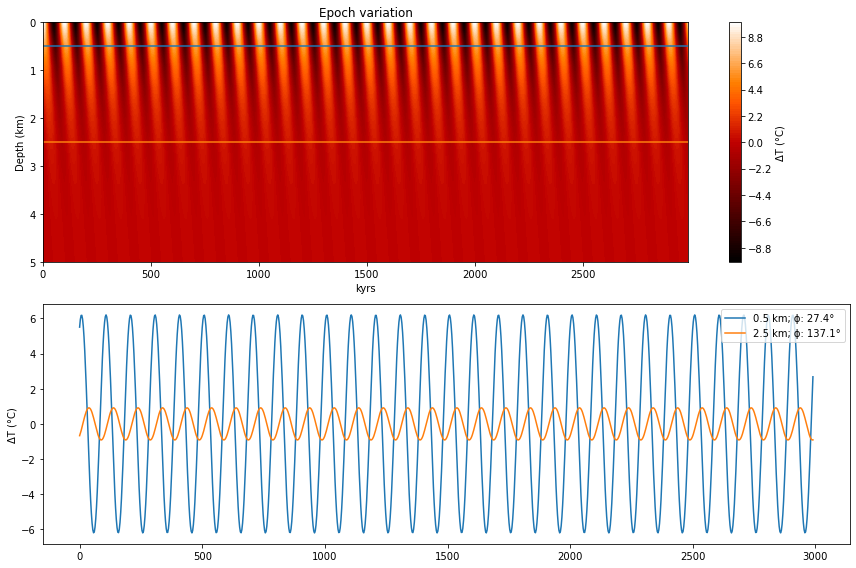

In [21]:
t0 = 10


# plt.plot(tt,fztp(0,tt,t0,ww,p,cp,k),'-')
tau = dt.timedelta(days=365.25).total_seconds()*1e5
ww = fw(tau)

nyears = 3e6
tt = np.linspace(0,dt.timedelta(weeks=52).total_seconds()*nyears,1000)
dd = np.linspace(0,45e3,100)

xtm,ytm = np.meshgrid(tt,dd)

ddc = [0.5,2.5]

xtm,ytm = np.meshgrid(tt,dd)

fig = plt.figure(figsize=(12,8))
ax = fig.subplots(2,1)


ff = ax[0].contourf(xtm/tau*100,ytm/1e3,fztp(ytm,xtm,t0,ww,p,cp,k),cmap='gist_heat',levels=100)
ax[0].set_xlabel('kyrs')
ax[0].set_ylim([5,0])
ax[0].set_ylabel('Depth (km)')
ax[0].set_title('Epoch variation');
fig.colorbar(ff,ax=ax[0],label='ΔT (°C)');

ax[0].axhline(ddc[0],color='tab:blue')
ax[0].axhline(ddc[1],color='tab:orange')

for td in ddc:
    ax[1].plot(tt/tau*100,fztp(td*1e3,tt,t0,ww,p,cp,k),'-',label='%.1f km; ɸ: %.1f°'%(td,np.degrees(fPhi(td*1e3,ww))))

ax[1].legend()
ax[1].set_ylabel('ΔT (°C)')
# ax[1].set_xticks([dt.timedelta(days=int(x)).total_seconds() for x in np.arange(nweeks*7)][::28],
#               labels=np.arange(nweeks*7)[::28])
# ax[1].set_xlabel('Days')

fig.tight_layout();

# Ocean lithospheric thickness (age)

In [214]:
ta = 1300
tl = 1100

ka = 1e-6
k=2.5
pa=3.3e3
pw=1.03e3
alpha = 3e-5

dr = 2.6e3

In [215]:
fLith = lambda t: sp.special.erfinv(1100/1300)*2*np.sqrt(ka*t)

In [216]:
fMyr = lambda t: dt.timedelta(weeks=52).total_seconds()*1e6*t

In [217]:
fpz = lambda t, pa, alpha, ta : pa*(1-alpha*(t-ta))

In [218]:
fdsim = lambda t,dr,alpha,ta,pa,pw,ka: dr + ((2*pa*alpha*ta)/(pa-pw))*((ka*t)/np.pi)**0.5

Text(0.5, 1.0, 'lithosphere base')

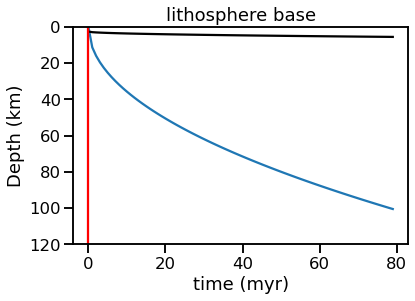

In [219]:
tmyr = np.arange(80)

plt.plot(tmyr,fLith(fMyr(tmyr))/1e3,'-',color='tab:blue')
plt.plot(tmyr,fdsim(fMyr(tmyr),dr,alpha,1200,pa,pw,ka)/1e3,'-k')


plt.axvline(0,color='red')

plt.ylim([120,0])

plt.xlabel('time (myr)')
plt.ylabel('Depth (km)')

plt.title('lithosphere base')

Text(0.5, 1.0, 'Seafloor - simple model')

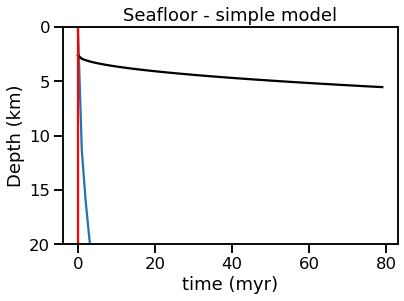

In [220]:
tmyr = np.arange(80)

plt.plot(tmyr,fLith(fMyr(tmyr))/1e3,'-',color='tab:blue')
plt.plot(tmyr,fdsim(fMyr(tmyr),dr,alpha,1200,pa,pw,ka)/1e3,'-k')


plt.axvline(0,color='red')

plt.ylim([20,0])

plt.xlabel('time (myr)')
plt.ylabel('Depth (km)')

plt.title('Seafloor - simple model')

# Heating in ocean lith

In [263]:
def halfspace(t):
    """
    simple half space cooling model, returns sea floor depth in km and heat flow in mW/m2 for age in myr
    """
    d = 2.6 + 0.345*t**0.5
    q = 480*t**-0.5
    
    return d,q/1e3

def psm(t):
    """
    parsons and scalter 1977
    """
        
    d = np.ones_like(t)*np.nan
    d[t<70] =  2.5 + 0.350*t[t<70]**0.5
    d[t>=70] = 6.4 - 3.2*np.exp(-t[t>=70]/62.8)
    
    q = np.ones_like(t)*np.nan
    q[t<120] = 473*t[t<120]**-0.5
    q[t>=120] = 33.5 + 67*np.exp(t[t>=120]/62.8)
        
    return d,q/1e3

def gdh(t):
    """
    global depth and heat
    """
    
    d = np.ones_like(t)*np.nan
    d[t<20] =  2.6 + 0.365*np.sqrt(t[t<20])
    d[t>=20] = 5.65 - 2.47*np.exp(-t[t>=20]/36)
    
    q = np.ones_like(t)*np.nan
    q[t<55] = 510/np.sqrt(t[t<55])
    q[t>=55] = 49 + 96*np.exp(-t[t>=55]/36)
    
    return d,q/1e3

In [264]:
def halfspace_temp(z,t,ta,ka):
    
    return ta*sp.special.erf(z/(2*np.sqrt(ka*t)))


In [265]:
mt,md = np.meshgrid(fMyr(tmyr),np.arange(0,150e3,1e3))

tzt = halfspace_temp(md,mt,1300,ka)

/var/folders/1s/wjx12t_j5h7gnb2g26c4dv8h0000gn/T/ipykernel_46015/3116544247.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return ta*sp.special.erf(z/(2*np.sqrt(ka*t)))
/var/folders/1s/wjx12t_j5h7gnb2g26c4dv8h0000gn/T/ipykernel_46015/3116544247.py:3: RuntimeWarning: invalid value encountered in true_divide
  return ta*sp.special.erf(z/(2*np.sqrt(ka*t)))


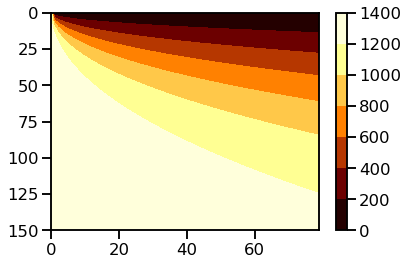

In [266]:
plt.contourf(mt/fMyr(1),md/1e3,tzt,cmap='afmhot')
plt.ylim([150,0])
plt.colorbar()

In [267]:
def geotherm_surf(z,q,a,k):
    return -(a/(2*k))*z**2 + q/k*z

In [268]:
zz = np.linspace(0,25e3,100)

gt = gdh(tmyr)
gtt = [geotherm_surf(zz,q,1.25e-6,2.5) for q in gt[1][1:]]

/var/folders/1s/wjx12t_j5h7gnb2g26c4dv8h0000gn/T/ipykernel_46015/130133078.py:35: RuntimeWarning: divide by zero encountered in true_divide
  q[t<55] = 510/np.sqrt(t[t<55])


(25.0, 0.0)

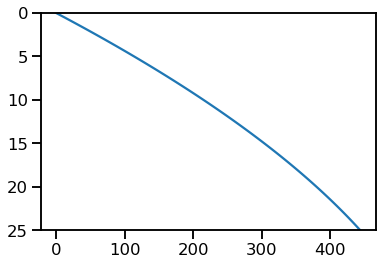

In [279]:
plt.plot(gtt[77],zz/1e3)
plt.ylim([25,0])


# Jaeger RoG equations

In [82]:
ftau = lambda t,d,k: k*t/(d**2)
fxi = lambda x,d: x/d

fphi = lambda xi,tau : 0.5 * (sp.special.erf((xi+1)/(2*np.sqrt(tau))) - sp.special.erf((xi-1)/(2*np.sqrt(tau))))

flatent = lambda t0,L,c : t0 + L/c

## Case i) contact temp over time

In [58]:
t0 = 1000
ka = 1e-6
d = 1

fctj = lambda t,t0,d,k: t0/2 * sp.special.erf(1/np.sqrt(ftau(t,d,k)))

/var/folders/1s/wjx12t_j5h7gnb2g26c4dv8h0000gn/T/ipykernel_46015/3457064412.py:5: RuntimeWarning: divide by zero encountered in true_divide
  fctj = lambda t,t0,d,k: t0/2 * sp.special.erf(1/np.sqrt(ftau(t,d,k)))
/var/folders/1s/wjx12t_j5h7gnb2g26c4dv8h0000gn/T/ipykernel_46015/3457064412.py:5: RuntimeWarning: divide by zero encountered in true_divide
  fctj = lambda t,t0,d,k: t0/2 * sp.special.erf(1/np.sqrt(ftau(t,d,k)))


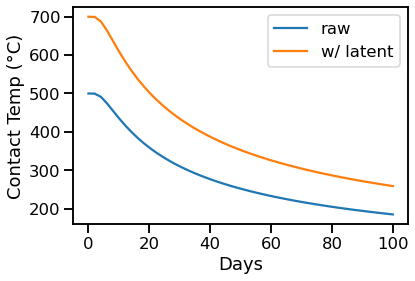

In [84]:
sns.set_context('talk')
td = dt.timedelta(days=1).total_seconds() # characteristic time, 1 day in seconds
tds = np.linspace(0,100,50)*td # 100 days in seconds

plt.plot(tds/td,fctj(tds,t0,d,ka),'-',label='raw')
plt.plot(tds/td,fctj(tds,flatent(t0,4e5,1e3),d,ka),'-',label='w/ latent')
plt.xlabel('Days')
plt.ylabel('Contact Temp (°C)')
plt.legend()

## Case ii) buried sill infinite depth, initial temp T0

In [79]:
d = 1 # height of sill is 2d
t0 = 1000 # temp difference between country and sill
ka = 1e-6


td = dt.timedelta(days=1).total_seconds() # characteristic time, 1 day in seconds
tds = np.linspace(0,10,11)*td # ten days in seconds

zm = np.linspace(-10,10,100); # relative depth in meters from center of sill

# xi = fxi(zm,d) # dimensionless depth
# tau = ftau(tds,d) # dimensionless time

ftdj = lambda z,t,d,t0,k: t0*fphi(fxi(z,d),ftau(t,d,k))


/var/folders/1s/wjx12t_j5h7gnb2g26c4dv8h0000gn/T/ipykernel_46015/2906312502.py:4: RuntimeWarning: divide by zero encountered in true_divide
  fphi = lambda xi,tau : 0.5 * (sp.special.erf((xi+1)/(2*np.sqrt(tau))) - sp.special.erf((xi-1)/(2*np.sqrt(tau))))


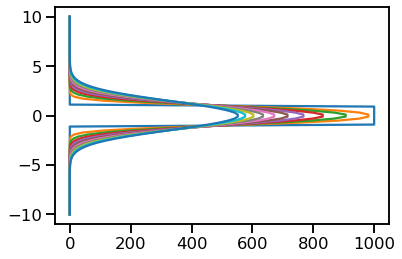

In [81]:
%matplotlib inline

fig = plt.figure()
ax = fig.subplots(1,1)

for tt in tds:
    ax.plot(ftdj(zm,tt,d,t0,ka),zm,'-')


In [36]:
tdif = ftdj(zm,tds[1],d,t0,ka) - tempdist(zm,tds[1],d,t0,ka)
print(dt.timedelta(seconds=tds[1]),tdif)

1 day, 0:00:00 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


## Case iii: infinite cylinder (heat pipe), constant Temp

In [138]:
t0 = 1000 # temp difference between country and sill
ka = 1e-6

td = dt.timedelta(days=1).total_seconds() # characteristic time, 1 day in seconds
tds = np.linspace(0,30,301)*td # ten days in seconds

# assume rectangular cylinder for ease of gridding
# depth infinite
dx = 4 # width 4 m
dy = 3 # height 2 m

# define grid of x,y with center of pipe at origin
xv = np.linspace(-10,10,100)
yv = np.linspace(-10,10,100)

xm,ym = np.meshgrid(xv,yv)

# heat conduction equaton
ftpj = lambda x,y,t,dx,dy,t0,k : t0 * fphi(fxi(x,dx),ftau(t,dx,k)) * fphi(fxi(y,dy),ftau(t,dy,k)) 

In [139]:
def animate_pipe(ti):
    tt = tds[ti]
    zm = zmt[ti]
    
    plt.clf()
    plt.contourf(xm,ym,zm,cmap='magma',levels=100,vmin=0,vmax=1000)
    plt.colorbar()

    plt.title('time: %s'%dt.timedelta(seconds=tt))
    plt.plot([-dx,-dx,dx,dx,-dx],[-dy,dy,dy,-dy,-dy],'-',color='lime');

<IPython.core.display.Javascript object>


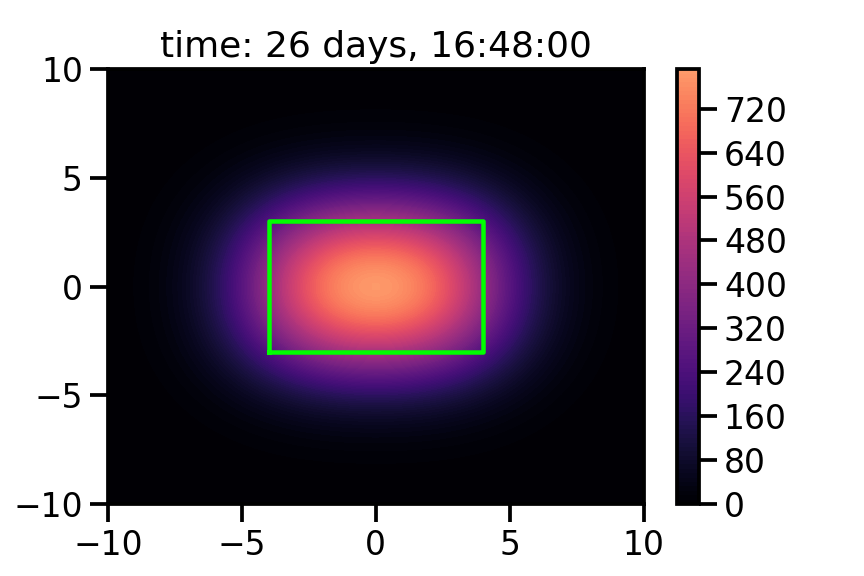

/var/folders/1s/wjx12t_j5h7gnb2g26c4dv8h0000gn/T/ipykernel_46015/3706095533.py:4: RuntimeWarning: divide by zero encountered in true_divide
  fphi = lambda xi,tau : 0.5 * (sp.special.erf((xi+1)/(2*np.sqrt(tau))) - sp.special.erf((xi-1)/(2*np.sqrt(tau))))


In [140]:
%matplotlib notebook

fig = plt.figure()
ax = fig.subplots(1,1)

zmt = [ftpj(xm,ym,tt,dx,dy,t0,ka) for tt in tds]

anim = animation.FuncAnimation(fig,animate_pipe,interval=1,frames=len(tds),repeat=True)

anim

## Case iv: 3D parallelepiped

In [281]:
t0 = 1000 # temp difference between country and sill
ka = 1e-6

td = dt.timedelta(days=1).total_seconds() # characteristic time, 1 day in seconds
tds = np.linspace(0,10,11)*td # ten days in seconds

# assume rectangular cylinder for ease of gridding

dx = 2 # width 4 m
dy = 1 # height 2 m
dz = 3 # depth 3 m

# define grid of x,y,z with center of batholith at origin
xv = np.linspace(-10,10,100)
yv = np.linspace(-10,10,100)
zv = np.linspace(-10,10,100)

xm,ym,zm = np.meshgrid(xv,yv,zv,indexing='ij')

# heat conduction equaton
ftbj = lambda x,y,z,t,dx,dy,dz,t0,k : t0 * fphi(fxi(x,dx),ftau(t,dx,k)) *\
                                           fphi(fxi(y,dy),ftau(t,dy,k)) *\
                                           fphi(fxi(z,dz),ftau(t,dz,k))

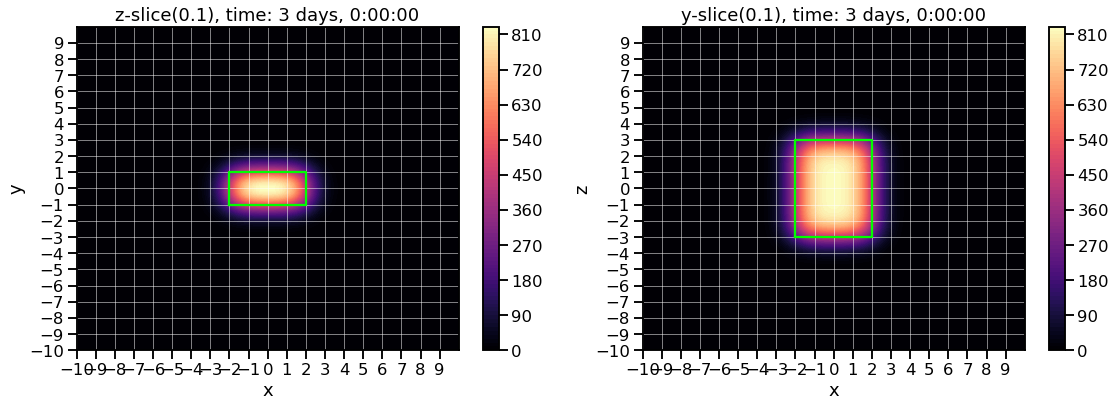

In [285]:
%matplotlib inline

sns.set_context('talk')

tt = tds[3]

tmt = ftbj(xm,ym,zm,tt,dx,dy,dz,t0,ka)

fig = plt.figure(figsize=(16,6))
ax = fig.subplots(1,2)

ah = ax[0].contourf(xm[:,:,50],ym[:,:,50],tmt[:,:,50],cmap='magma',levels=100)
fig.colorbar(ah,ax=ax[0])

ax[0].plot([-dx,-dx,dx,dx,-dx],[-dy,dy,dy,-dy,-dy],'-',color='lime')
ax[0].set_xticks(np.arange(xv[0],xv[-1],1))
ax[0].set_yticks(np.arange(yv[0],yv[-1],1))
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('z-slice(%.1f), time: %s'%(zv[50],dt.timedelta(seconds=tt)))
ax[0].grid(color='w',linewidth=0.5)

ahz = ax[1].contourf(xm[:,50,:],zm[:,50,:],tmt[:,50,:],cmap='magma',levels=100)
fig.colorbar(ahz,ax=ax[1])

ax[1].plot([-dx,-dx,dx,dx,-dx],[-dz,dz,dz,-dz,-dz],'-',color='lime')
ax[1].set_xticks(np.arange(xv[0],xv[-1],1))
ax[1].set_yticks(np.arange(zv[0],zv[-1],1))
ax[1].set_xlabel('x')
ax[1].set_ylabel('z')
ax[1].set_title('y-slice(%.1f), time: %s'%(yv[50],dt.timedelta(seconds=tt)))
ax[1].grid(color='w',linewidth=0.5)

fig.tight_layout()

In [295]:
ftbj(dx,dy,dz,tt,dx,dy,dz,t0,ka)

124.31584611324423

In [286]:
import pyvista as pv

In [291]:
grid = pv.StructuredGrid(xm, ym, zm)
grid["vol"] = tmt.flatten()
contours = grid.contour([100,300,500])
grid.save('heat_cube_v01.vtk')

# grid.plot(volume=True, cmap="magma",opacity='sigmoid',background="grey")

# pl.set_background('black', top='white')

#%% Visualization
# pv.set_plot_theme('document')
# p = pv.Plotter()
# p.add_mesh(contours, scalars=contours.points[:, 2], show_scalar_bar=True)
# p.show()

## Case IX: parallel intrusions

In [42]:
t0 = 1000 # temp difference between country and sill
ka = 1e-6

td = dt.timedelta(days=1).total_seconds() # characteristic time, 1 day in seconds
tds = np.linspace(0,10,11)*td # ten days in seconds

# assume rectangular cylinder for ease of gridding
d1 = 1 # sheet1 thick 2m
d2 = 1 # sheet2 thick 2m

ldist = 4 # separated by 2 m

# define depth
zm = np.linspace(-15,15,100)

# heat conduction equaton
ftppj = lambda x,t,d1,d2,ldist,t0,k : t0 * fphi(fxi(x,d1),ftau(t,d1,k)) +\
                                      t0 * fphi(fxi((ldist-x),d2),ftau(t,d2,k))

/var/folders/1s/wjx12t_j5h7gnb2g26c4dv8h0000gn/T/ipykernel_46015/2906312502.py:4: RuntimeWarning: divide by zero encountered in true_divide
  fphi = lambda xi,tau : 0.5 * (sp.special.erf((xi+1)/(2*np.sqrt(tau))) - sp.special.erf((xi-1)/(2*np.sqrt(tau))))
/var/folders/1s/wjx12t_j5h7gnb2g26c4dv8h0000gn/T/ipykernel_46015/2906312502.py:4: RuntimeWarning: invalid value encountered in true_divide
  fphi = lambda xi,tau : 0.5 * (sp.special.erf((xi+1)/(2*np.sqrt(tau))) - sp.special.erf((xi-1)/(2*np.sqrt(tau))))


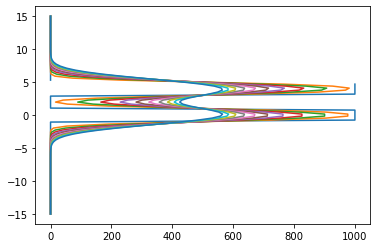

In [43]:
%matplotlib inline

fig = plt.figure()
ax = fig.subplots(1,1)

for tt in tds:
    ax.plot(ftppj(zm,tt,d1,d2,ldist,t0,ka),zm,'-')

## Case X: surface cover

In [44]:
t0 = 1000 # temp difference between country and sill
ka = 1e-6

td = dt.timedelta(days=1).total_seconds() # characteristic time, 1 day in seconds
tds = np.linspace(0,10,11)*td # ten days in seconds

# assume rectangular cylinder for ease of gridding
d = 1 # sheet thick 2m

ldist = 1 # cover thickness (to sill edge)

# define depth
zm = np.linspace(-15,ldist+d,100)

# heat conduction equaton
ftscj = lambda x,t,d,ldist,t0,k : t0 * fphi(fxi(x,d),ftau(t,d,k)) -\
                                      t0 * fphi(fxi((2*ldist+2*d-x),d),ftau(t,d,k))

/var/folders/1s/wjx12t_j5h7gnb2g26c4dv8h0000gn/T/ipykernel_46015/2906312502.py:4: RuntimeWarning: divide by zero encountered in true_divide
  fphi = lambda xi,tau : 0.5 * (sp.special.erf((xi+1)/(2*np.sqrt(tau))) - sp.special.erf((xi-1)/(2*np.sqrt(tau))))


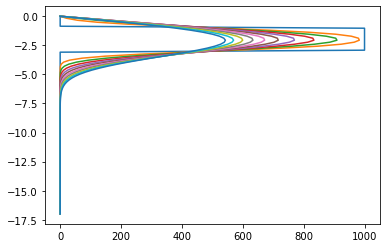

In [45]:
%matplotlib inline

fig = plt.figure()
ax = fig.subplots(1,1)

for tt in tds:
    ax.plot(ftscj(zm,tt,d,ldist,t0,ka),zm-(ldist+d),'-')
    
# ax.set_yticks(np.arange(zm[0],zm[-1]+1e-5,1));

## Section 5: Latent heat and solidification

Inverting eqn 33 to find lambda given latent/specific heat

In [46]:
d = 1 # m
L = 4e5 # J/kg
t1 = 1100 # temp c
c = 1e3 # J/kgC, magma

xref = c*t1/(L*np.pi**0.5)

lamx = lambda x: x*(1+sp.special.erf(x))*np.exp(x**2)
flamx = lambda x: np.abs(lamx(x)-xref)



In [47]:
res = sp.optimize.minimize(flamx,1)

In [48]:
res

      fun: 3.609162924078646e-08
 hess_inv: array([[0.51053299]])
      jac: array([0.28627998])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 72
      nit: 2
     njev: 30
   status: 2
  success: False
        x: array([0.63531852])

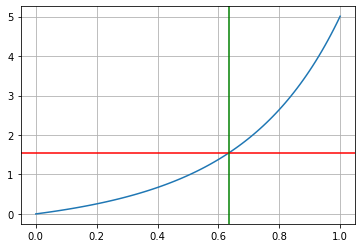

In [49]:
xg = np.linspace(0,1,100)

plt.plot(xg,lamx(xg),'-')
plt.grid()
plt.axhline(xref,color='r')
plt.axvline(res.x[0],color='g')

## case xii: geotherm with intrusion

In [212]:
t0 = 1000 # temp difference between country and sill
ka = 1e-6

td = dt.timedelta(days=1).total_seconds() # characteristic time, 1 day in seconds
tds = np.linspace(0,100,11)*td # ten days in seconds

d = 50 # sheet thick 2m

ldist = 500 # cover thickness (to sill edge)

# define depth
zm = np.linspace(0,10e3,1000)

# define initial geotherm
case_A = {'id':'A', 'd':50e3, 'k':2.5, 'a':1.25e-6, 'qd':21e-3}
gt = geotherm(zm,case_A['d'],case_A['k'],case_A['qd'],case_A['a'])

# initial temp by depth
def get_init_geotherm(zm,gt,d,L):
    gtn = np.ones_like(zm)
    for ii,(z,g) in enumerate(zip(zm,gt)):
        if z<L:
            gtn[ii] = g
        elif (z>L)&(z<(L+2*d)):
            gl = geotherm(L,case_A['d'],case_A['k'],case_A['qd'],case_A['a'])
            gtn[ii] = gl + t0
        else:
            gtn[ii] = geotherm(z-(2*d),case_A['d'],case_A['k'],case_A['qd'],case_A['a'])
    return gtn

gtn = get_init_geotherm(zm,gt,d,ldist)

# gradient at the surface
def get_hot_geotherm(t,g,t0,ka,d,L):
    t1 = (2*g*d)/np.sqrt(np.pi*ka*t)
    t2 = (6*d*t0*(L+d) + g*d*(3*L**2 + 6*L*d + 4*d**2)) / (6*np.sqrt(np.pi)*(ka*t)**(3/2))
    
    return g - t1 + t2

gdt0 = np.diff(gtn)[0]
gdtt = [get_hot_geotherm(t,30e-3,t0,ka,d,ldist) for t in tds[1:]]

In [213]:
gdt0,gdtt

(0.33430928425923423,
 [19478931.213999704,
  6886841.551445811,
  3748721.383332663,
  2434865.745157194,
  1742247.9487885362,
  1325372.803167645,
  1051762.8628997905,
  860854.7373379738,
  721441.3861736036,
  615977.4010299706])

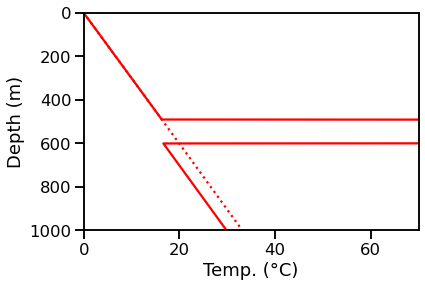

In [196]:
%matplotlib inline

fig = plt.figure()
ax = fig.subplots(1,1)

ax.plot(gt,zm,':r')
ax.plot(gtn,zm,'-r')
ax.set_ylim([1000,0])
ax.set_xlim([0,70])
ax.set_xlabel('Temp. (°C)')
ax.set_ylabel('Depth (m)');

# Mantle adiabat

In [297]:
alpha = 3e-5
t0 = 1427
g = 9.81
cp = 1.25e3

fmag = lambda t0,alpha,g,cp: -t0*alpha*g/cp

In [330]:
mbz = 80e3

zm = np.linspace(0,mbz,1000)
gt = geotherm(zm,mbz,2.5,0.021,0.60e-6)

zma = np.linspace(mbz,2500e3,1000)

gmadr = -fmag(t0,alpha,g,cp)

gma = gmadr*zma + t0

Text(0, 0.5, 'Depth (km)')

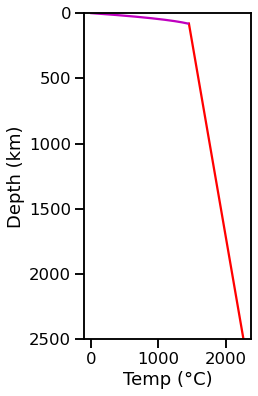

In [340]:
fig = plt.figure(figsize=(3,6))
ax = fig.subplots(1,1)

ax.plot(gma,zma/1e3,'-r')
ax.plot(gt,zm/1e3,'-m')
ax.set_ylim([zma[-1]/1e3,0])

ax.set_xlabel('Temp (°C)')
ax.set_ylabel('Depth (km)')

0.00033